# Exploring Hate Crimes and Antisemitism

# Introduction  
Hate crimes, particularly those targeting specific groups like antisemitism, pose a significant challenge globally. In this project, we aim to analyze hate crime data to understand trends related to antisemitic incidents.

The Federal Bureau of Investigation reported 6,270 hate crimes in the US in 2016, 7,868 in 2019, and 11,643 in 2022--an 85% increase over six years. In response to this alarming surge in hate crimes across the nation, we present a comprehensive model aimed at tracking and analyzing this disturbing trend. The escalating incidence of hate-motivated offenses underscores the urgent need for proactive measures to understand the trends so they can be addressed.

The dataset sources we'll utilize include the FBI data, which provides comprehensive hate crime records from 1991 to 2022. We then intend to additionally utilize data from the Anti-Defamation League (ADL) for more information on recent years.


## Hypothesis
As trends continue the quantity of reported hate crimes has and will continue to increase without external intent to limit them.

### Why is this important?
 - Enhancing Public Safety: Increasing hate crimes normalizes hate and risks the safety and security of all communities. It further contributes to increasing divides between societal groups.
 - Economic Impact: Hate crimes can lead to increased costs for law enforcement, healthcare, and other necessary support services.
 - Human Rights: Addressing hate crimes is essential for protecting the rights and dignity of all individuals, promoting equality and justice
Bringing attention to trends in hate crimes is the first step towards encouraging action to limit them.

We begin by importing necessary libraries:

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeRegressor

C:\Users\eitan\AppData\Local\Temp\ipykernel_53640\4025613340.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Collection 

This tutorial utilizes a dataset acquired from the Federal Bureau of Investigation. The hate_crime.csv file contains 241,664 hate crimes between 1991 and 2022. 

The database was manually downloaded from a public FBI repository and added to this repository as a csv file and then accessed through a read_csv call, reading the spreadsheet into a DataFrame.

Each hate crime is identified based on the following categories: 
incident_id, data_year, ori, pug_agency_name, pub_agency_unit, agency_type_name, state_abbr, state_name, division_name, region_name, population_group_code, population_group_description, incident_date, adult_victim_count, juvenile_victim_count, total_offender_count, adult_offender_count, juvenile_offender_count, offender_race, offender_ethnicity, victim_count, offense_name, total_individual_victims, location_name, bias_desc, victim_types, multiple_offense, multiple_bias.

For the purpose of this study we are considering data_year (year the incident was reported), state_name (where the incident occurred), agency_type_name (where it occurred--city, county, university, etc), bias_desc (what subgroups were impacted in the incident), offense_name (what type of incident occurred), and incident_date (date the incident occurred). In addition to not requiring the other columns for this particular study, these columns were all completed for every data entry. All other columns were filtered out of the dataframe.

The bias_desc identifies the various types of hate crimes listed, identifying each by the group targeted by the attack.

Before beginning data analysis and prediction, we cleaned the data to remove unneeded columns and to combine similar categories for better representation of types of hate crimes.


Reading the FBI data from a csv file:

In [2]:
#Load from csv file
file_path = 'hate_crime.csv'

#read into a DataFrame
all_data = pd.read_csv(file_path)

Preemptively reading the ADL data for recent years to complement the FBI dataset.

In [3]:
#import data from the ADL on antisemetic incidents 
adl_file_path = 'HEATMapData (1).csv'

#read into a DataFrame
adl_data = pd.read_csv(adl_file_path)

## Data Processing
In this section, we focus on selecting the columns that are relevant for our analysis from the hate crime dataset. We start by examining all the column names to understand the available features in our dataset. This step helps us identify which columns we need to proceed with for further analysis, as well as to clearly display the columns included. Next, we check for missing values across all columns to assess the data quality. If there are missing values, we'll need to decide how to handle them. In this case, we may choose to drop rows with missing data assuming they are unneeded for our later analyses. 

Finally, we create a new DataFrame named only_relevant containing only the selected relevant columns for our analysis.

We followed a similar process for the ADL data. 

In [4]:
#Preprocessing: Selecting relevant columns
column_names = all_data.columns.tolist()
print(column_names)

# Checking missing values
missing_values = all_data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Selecting relevant data that we wish to remain in our Dataframe
only_relevant = all_data[['data_year','state_name', 'agency_type_name', 'bias_desc', 'offense_name', 'incident_date']]
print(only_relevant)


['incident_id', 'data_year', 'ori', 'pug_agency_name', 'pub_agency_unit', 'agency_type_name', 'state_abbr', 'state_name', 'division_name', 'region_name', 'population_group_code', 'population_group_description', 'incident_date', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'offender_race', 'offender_ethnicity', 'victim_count', 'offense_name', 'total_individual_victims', 'location_name', 'bias_desc', 'victim_types', 'multiple_offense', 'multiple_bias']
Missing Values:
incident_id                          0
data_year                            0
ori                                  0
pug_agency_name                      0
pub_agency_unit                 234474
agency_type_name                     0
state_abbr                           0
state_name                           0
division_name                        0
region_name                          0
population_group_code              555
population_group_descri

Processing the ADL data, collecting comparable data from the set. 

In [5]:


adl_relevant = adl_data[['date','state', 'type', 'description']]

# Create new column of "data_year"
adl_relevant['date'] = pd.to_datetime(adl_relevant['date'], errors='coerce')

# Extract year and create a new column
adl_relevant['data_year'] = adl_relevant['date'].dt.year

# Split the 'type' column into two separate columns
adl_relevant[['bias_type', 'offense type']] = adl_relevant['type'].str.split(':', n=1, expand=True)

# Drop the original 'type' column
adl_relevant.drop(columns=['type'], inplace=True)

C:\Users\eitan\AppData\Local\Temp\ipykernel_53640\51775249.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adl_relevant['date'] = pd.to_datetime(adl_relevant['date'], errors='coerce')
C:\Users\eitan\AppData\Local\Temp\ipykernel_53640\51775249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adl_relevant['data_year'] = adl_relevant['date'].dt.year
C:\Users\eitan\AppData\Local\Temp\ipykernel_53640\51775249.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

## Exploratory Data Analysis:
Exploratory Data Analysis serves as a crucial initial step in understanding the multifaceted landscape of hate crimes. By delving into both FBI and ADL datasets, we are looking to identify time-based, location-based, and categorical insights into hate-motivated incidents across the United States. Through  data cleaning, visualization, and interpretation, we attempt to identify patterns and trends trends, and shed light on the diverse nature of hate crimes targeting various demographic groups. 

### Exploratory Data Analysis (EDA) on FBI Hate Crime Data
FBI Hate Crime Data:
In this section, we delve into the FBI dataset containing hate crime reports spanning several years. We are specifically focusing on crime rates over time, states in which they occur, types of offenses and the biases that motivate the crimes. Having already cleaned the data, handled missing values, and selected relevant columns for investigation, we can now detect trends and begin to analyze the data. 

Key Steps in FBI EDA:  
- Temporal Trends Analysis: We analyze temporal trends by examining the total number of hate crimes reported each year. Line plots and bar graphs are used to visualize changes in hate crime counts over time and identify any notable spikes or declines.

- Spatial Analysis: Spatial analysis involves exploring the geographical distribution of hate crimes. Bar graphs and choropleth maps are employed to visualize hate crime incidence by state, enabling us to identify regions with higher prevalence and variations over time.

- Bias Type Distribution: We investigate the distribution of hate crimes across different bias types. Pie charts and bar graphs illustrate the proportions of hate crimes targeting various groups, such as racial, religious, or LGBTQ+ communities.



#### Total Hate Crimes Over the Years

We start by examining trends of the total number of hate crimes reported each year, betweeen 1990 and 2022. 

In the graph below, we notice an overall upward trend in hate crime incidents, with noticeable early spikes in 1996, 2001, and 2008. Starting from 2014 until the final year, 2022, there is a large rise in reported incidents every year.

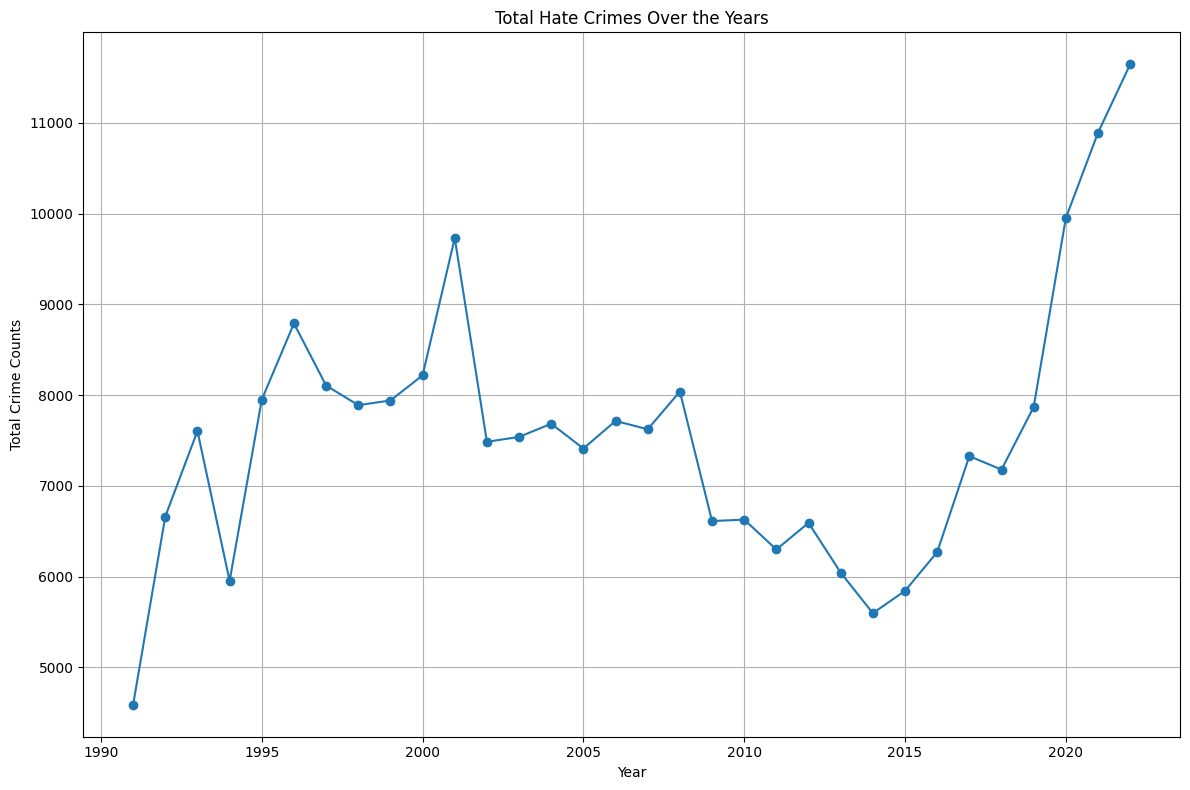

In [6]:
# Group the data by 'data_year' and count the total number of hate crimes for each year
total_crime_counts = only_relevant.groupby('data_year').size().reset_index(name='total_crimes')

# Plot total hate crimes over the years
plt.figure(figsize=(12, 8))
plt.plot(total_crime_counts['data_year'], total_crime_counts['total_crimes'], marker='o', linestyle='-')
plt.title('Total Hate Crimes Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Hate Crimes per Bias Type
Next, we explore hate crimes categorized by different bias types.  
This line plot illustrates the distribution of hate crimes across different bias types over the years.
Further detail will be provided below--This is meant to demonstrate the quantity of bias types analyzed, as well as a representation of some of those with higher quantities.

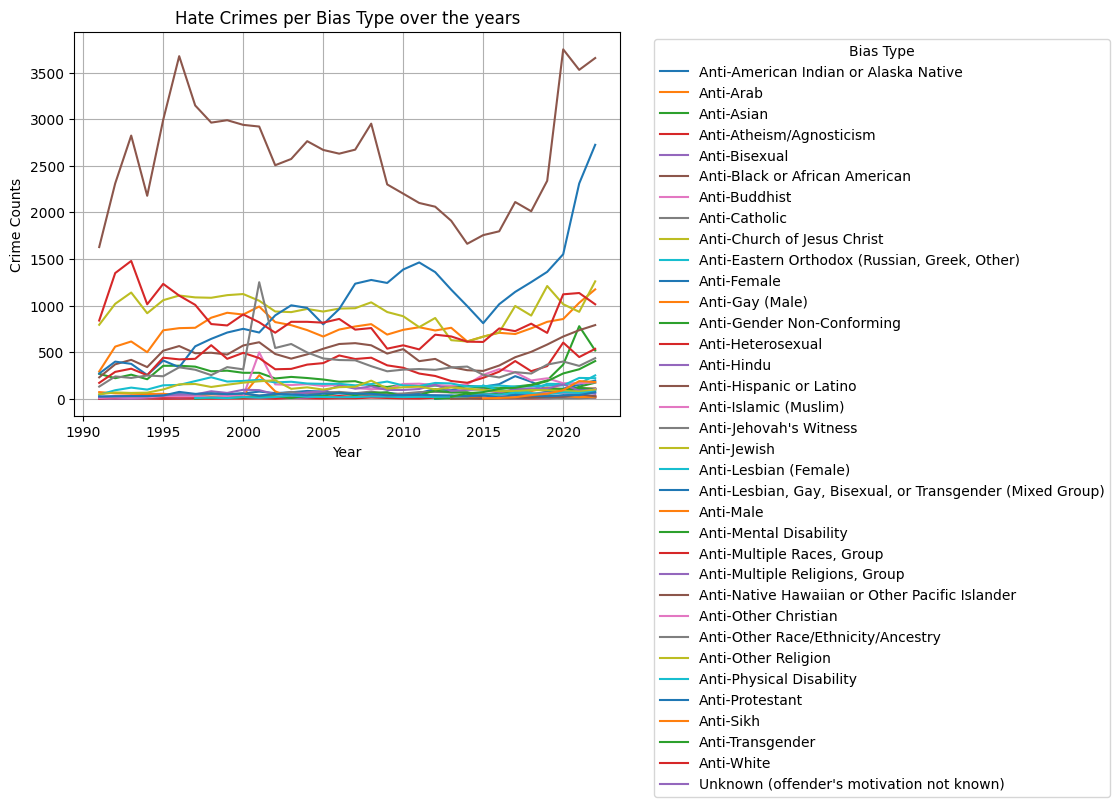

In [7]:
#Since the dataset includes multiple types of biases in each bias description, we first need to separate each bias type. 

og_expand = only_relevant.assign(bias_desc=only_relevant['bias_desc'].str.split(', ')).explode('bias_desc')
expanded_data = og_expand.assign(bias_desc=only_relevant['bias_desc'].str.split(';')).explode('bias_desc')

#We then calculate crime counts per bias type per year
crime_counts = expanded_data.groupby(['data_year', 'bias_desc']).size().reset_index(name='count_of_crimes')

pivot_table = crime_counts.pivot(index='data_year', columns='bias_desc', values='count_of_crimes')

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category)

plt.title('Hate Crimes per Bias Type over the years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()

plt.legend(title='Bias Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Percentage of Hate Crimes by State
Now, let's analyze the geographical distribution of hate crimes.  
This bar graph shows the percentage of hate crimes reported in each state. This information will be particularly useful in comparisons with more specific graphs further down.

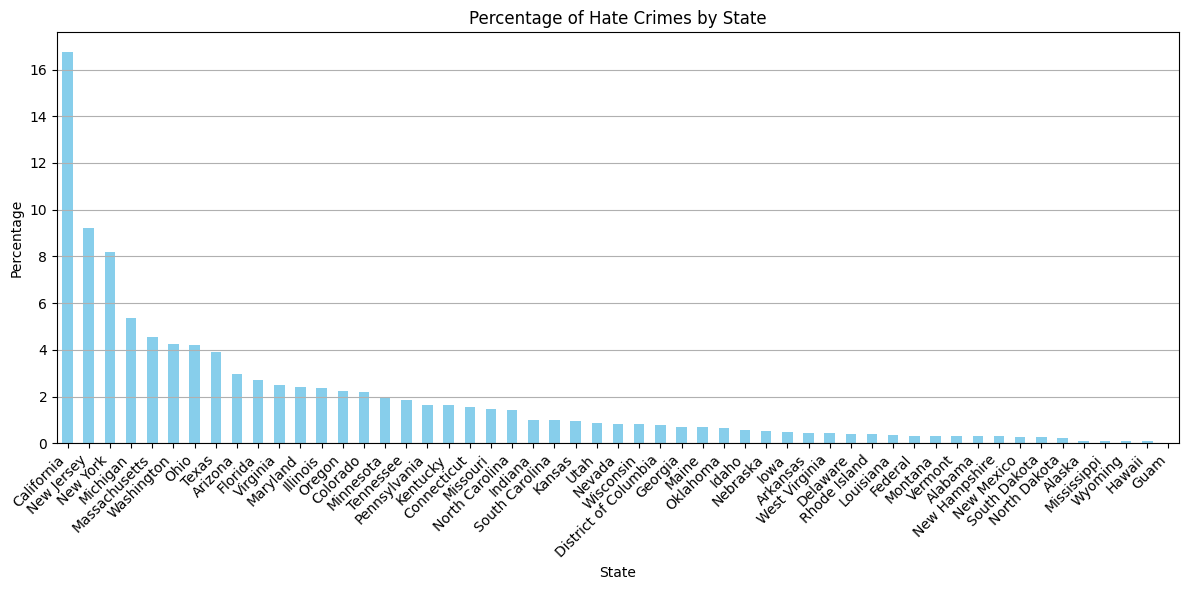

In [8]:
percentage_per_state = (expanded_data['state_name'].value_counts() / len(expanded_data)) * 100


# Plotting
plt.figure(figsize=(12, 6))
percentage_per_state.plot(kind='bar', color='skyblue')
plt.title('Percentage of Hate Crimes by State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.tight_layout()
plt.show()


#### Hate Crimes broken down into different offense types

We next broke down the information by type of offense that occurred. The FBI dataset contains all types of incidents so it is imperative to differentiate and better understand exactly what types of incidents are being reported.

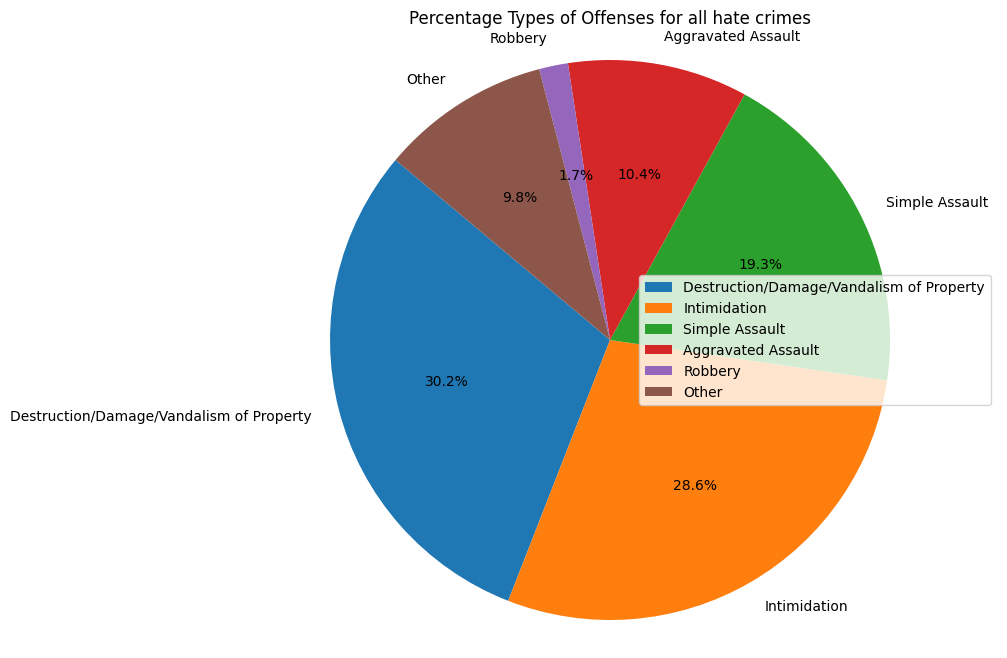

In [9]:
percentage_per_state = (expanded_data['offense_name'].value_counts() / len(expanded_data)) * 100


# Filter out categories with percentages less than 1.5%
other_threshold = 1.5
main_categories = percentage_per_state[percentage_per_state >= other_threshold]
other_categories = percentage_per_state[percentage_per_state < other_threshold]

# Combine the filtered categories into an "other" category
other_percentage = other_categories.sum()
main_categories['Other'] = other_percentage

# Plotting
plt.figure(figsize=(10, 8))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage Types of Offenses for all hate crimes')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend with the 'Other' category
plt.legend(main_categories.index, loc='best')

plt.show()


### Focus on antisemitic Hate Crimes in the FBI dataset.
Now that we have provided a representation of various forms of hate crimes, we are focusing in specifically on antisemitism. We begin with a visualization of antisemitism and will follow it up with a hypothesis and further models. 

#### Hate Crimes with Anti-Jewish Bias Over the Years
This line plot displays the trend of antisemitic hate crimes reported each year. Similar to the graph with all reported incidents there was a clearly increasing trend from 2014 through 2022, with the highest quantity of reported incidents over the entire range in 2022.

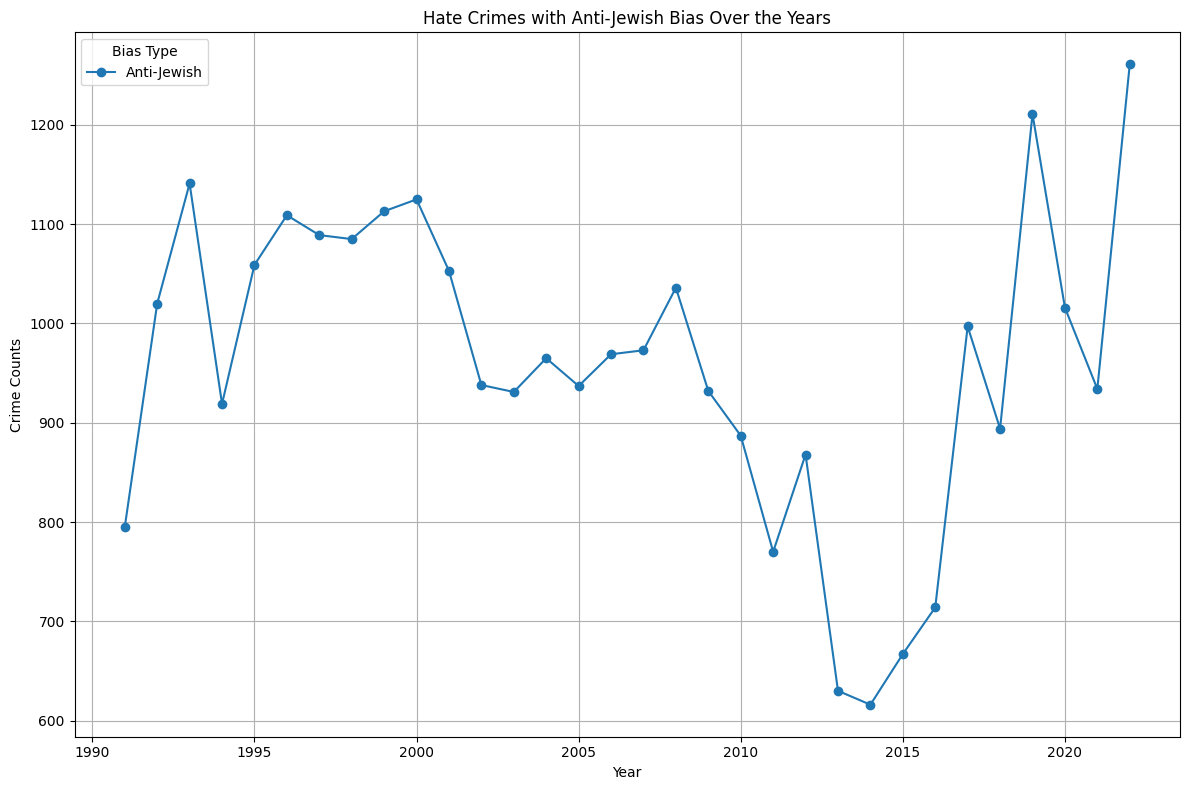

In [10]:
# Filter the expanded_data DataFrame to include only the rows with the "Anti-Jewish" bias category
anti_jewish_data = expanded_data[expanded_data['bias_desc'] == 'Anti-Jewish']

# Group the filtered data by 'data_year' and count the number of hate crimes for each year
crime_counts_anti_jewish = anti_jewish_data.groupby('data_year').size().reset_index(name='count_of_crimes')

# Plotting
plt.figure(figsize=(12, 8))

plt.plot(crime_counts_anti_jewish['data_year'], crime_counts_anti_jewish['count_of_crimes'], marker='o', label='Anti-Jewish')

plt.title('Hate Crimes with Anti-Jewish Bias Over the Years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Bias Type')
plt.show()


#### Percentage of Antisemitic Acts by State
Now, let's examine the geographical distribution of antisemitic hate crimes.  
This bar chart visualizes the percentage of antisemitic hate crimes reported in each state. Notice, the same three states hold the largest share, but to a greater extent here than in the previous graph.


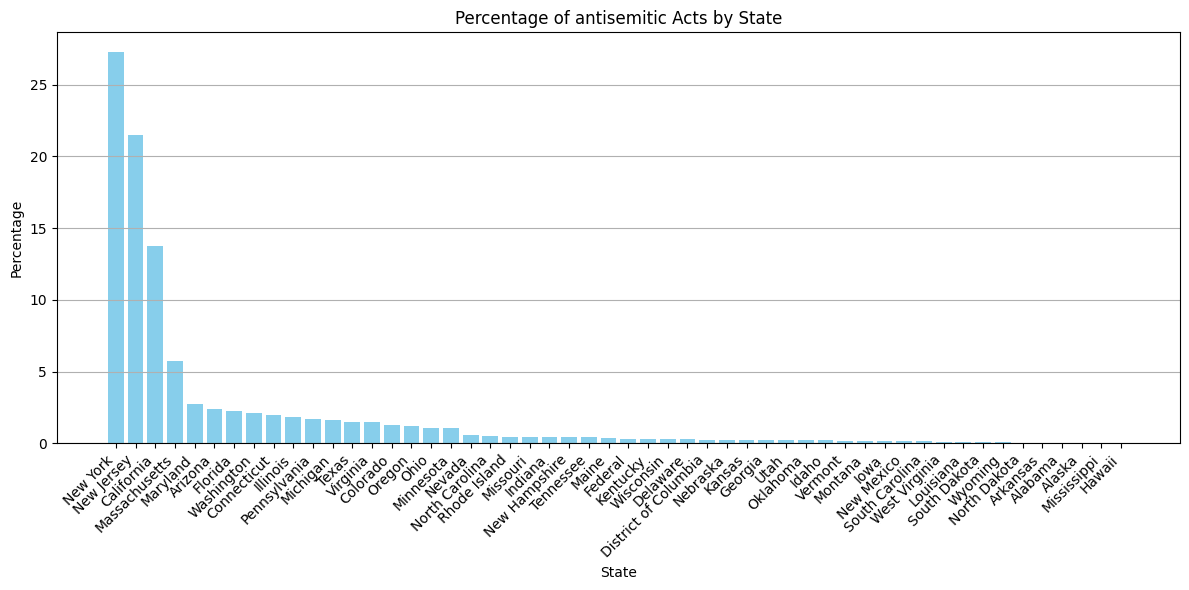

In [11]:
# Calculate the percentage of antisemitic acts by state
percentage_per_state = (anti_jewish_data['state_name'].value_counts() / len(anti_jewish_data)) * 100


# Plotting
plt.figure(figsize=(12, 6))
plt.bar(percentage_per_state.index, percentage_per_state, color='skyblue')

# Adding labels and title
plt.title('Percentage of antisemitic Acts by State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.tight_layout()

# Show plot
plt.show()


#### Types of antisemitic Offenses
Lastly, let's explore the types of offenses associated with antisemitic hate crimes.  
This pie chart illustrates the distribution of different types of offenses associated with antisemitic hate crimes. 64.4% of Anti-Jewish incidents were related to Destruction/Damage/Vandalism of Property and another 24.9% was Intimidation. 

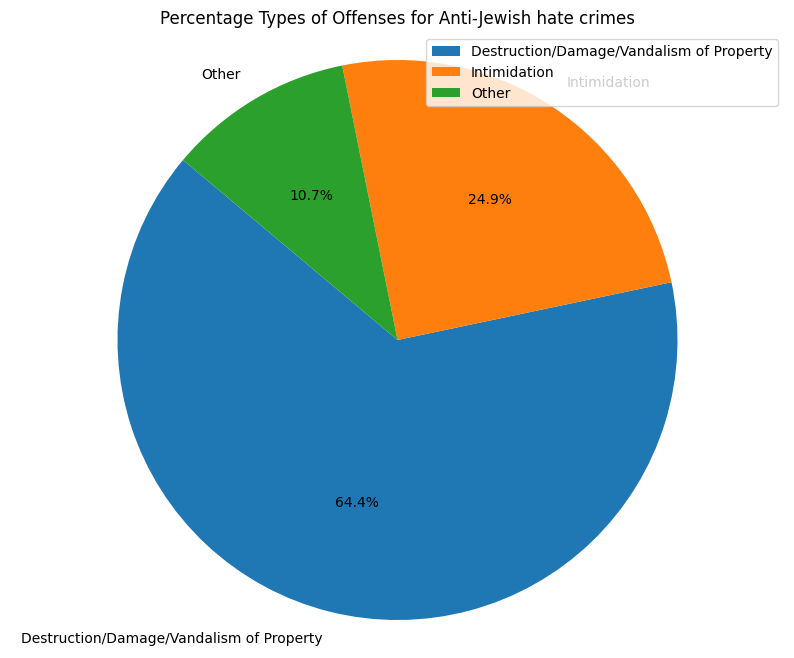

In [12]:
percentage_per_state = (anti_jewish_data['offense_name'].value_counts() / len(expanded_data)) * 100


# Filter out categories with percentages less than 1.5%
other_threshold = 1.5
main_categories = percentage_per_state[percentage_per_state >= other_threshold]
other_categories = percentage_per_state[percentage_per_state < other_threshold]

# Combine the filtered categories into an "other" category
other_percentage = other_categories.sum()
main_categories['Other'] = other_percentage

# Plotting
plt.figure(figsize=(10, 8))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage Types of Offenses for Anti-Jewish hate crimes')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend with the 'Other' category
plt.legend(main_categories.index, loc='best')

plt.show()


### ADL antisemitic Data:
In this section, we explore the ADL dataset, which provides insights into antisemitic incidents reported over recent years. EDA helps us understand the prevalence, nature, and distribution of antisemitic incidents across different regions and time periods.

The ADL dataset provides data from 2017 through 2023. Of particular note in the below graphs, the same three states were responsible for the highest proportion of incidents as in the FBI data. Additionally, harassment and vandalism were listed as the two most common sources of Anti-Jewish hate. 

Key Steps in EDA:

Data Cleaning and Preparation: Similar to the FBI data, we clean and preprocess the ADL dataset to ensure data quality and consistency. Missing values are handled, and relevant columns are selected for analysis.

Temporal Trends Analysis: We examine temporal trends in antisemitic incidents by plotting the number of incidents reported each year. Line plots highlight any changes or fluctuations in antisemitic activity over time.

Geographic Distribution Analysis: Spatial analysis involves visualizing the geographic distribution of antisemitic incidents. Bar graphs, choropleth maps, and pie charts depict the distribution of incidents by state, offering insights into regional variations and hotspots.

Incident Type Exploration: We explore the different types of antisemitic incidents reported in the dataset. Pie charts and bar graphs illustrate the prevalence of various types of incidents, such as harassment, vandalism, or assault.

Below is a breakdown of all incidents reported by the ADL. Beyond this graph the report will focus solely on Antisemitic incidents.

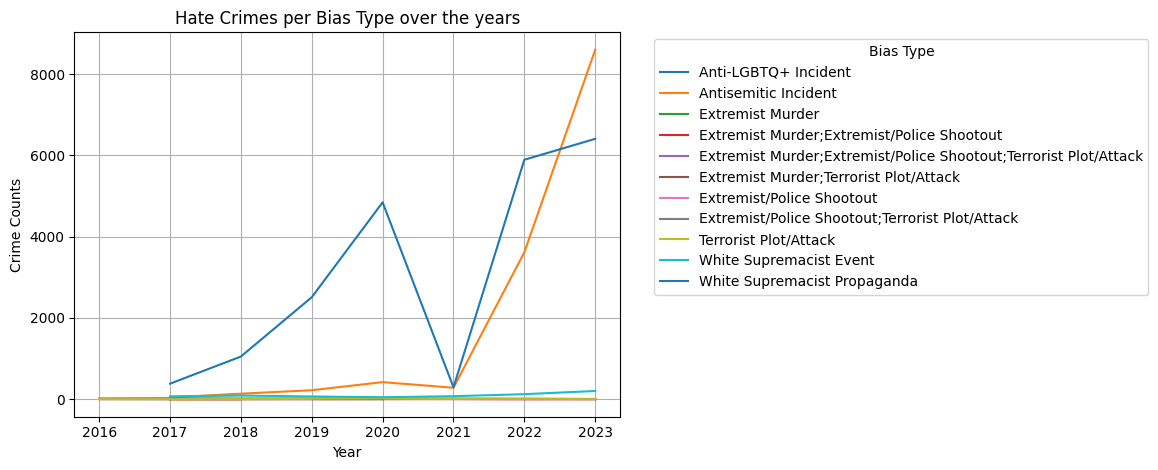

In [13]:
crime_counts = adl_relevant.groupby(['data_year', 'bias_type']).size().reset_index(name='count_of_crimes')

pivot_table = crime_counts.pivot(index='data_year', columns='bias_type', values='count_of_crimes')

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category)

plt.title('Hate Crimes per Bias Type over the years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()

plt.legend(title='Bias Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Zooming in specifically on antisemitic incidents, we see a minor increase in incidents between 2017 and 2021 before it skyrockets from only a few hundred incidents in 2021 to over 8000 in 2023.

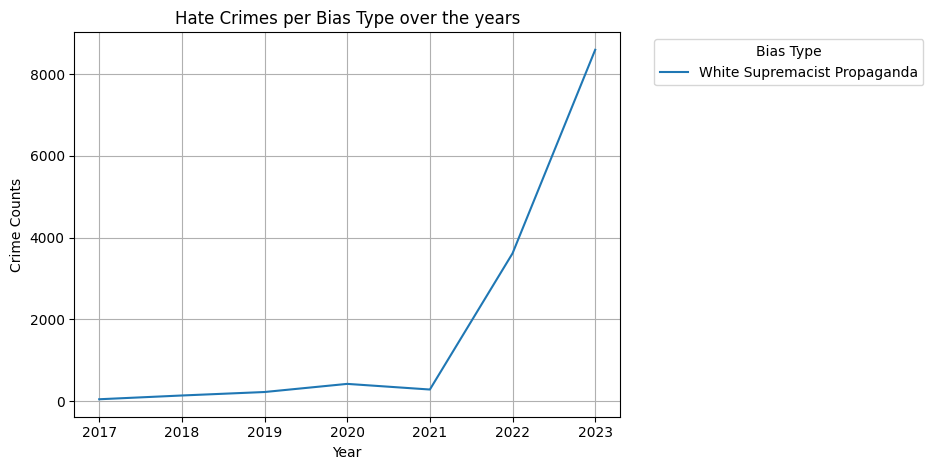

In [28]:
# # Filter the data for anti-Jewish hate crimes

crime_counts = adl_relevant.groupby(['data_year', 'bias_type']).size().reset_index(name='count_of_crimes')

pivot_table = crime_counts.pivot(index='data_year', columns='bias_type', values='count_of_crimes')

plt.plot(pivot_table.index, pivot_table['Antisemitic Incident'], label=category)

plt.title('Hate Crimes per Bias Type over the years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()

plt.legend(title='Bias Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Below we identify the most common states in which incidents were reported. The same three states, New York, California, and New Jersey account for the majority of hate crimes. 

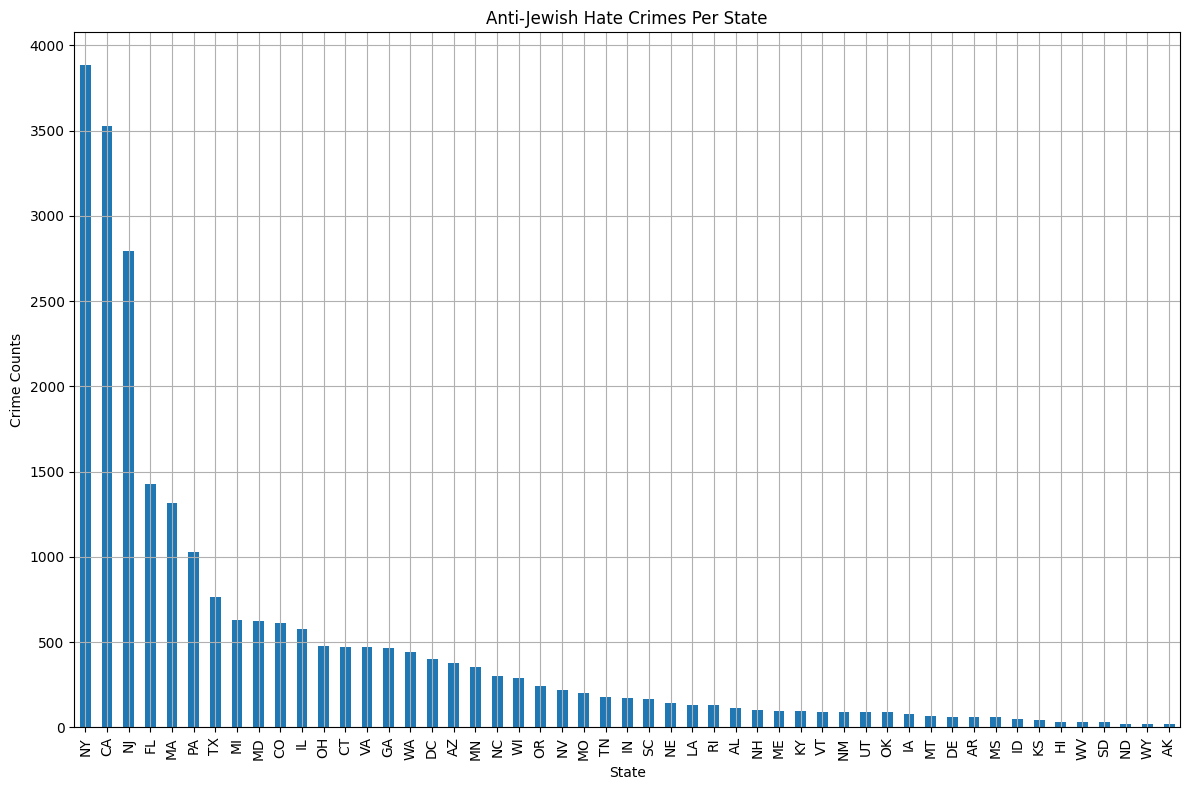

In [15]:
# Group the data by 'state' and count the number of hate crimes for each state
crime_counts_per_state = adl_antisemetic_data['state'].value_counts()

# Plotting
plt.figure(figsize=(12, 8))
crime_counts_per_state.plot(kind='bar')
plt.title('Anti-Jewish Hate Crimes Per State')
plt.xlabel('State')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()


The next graph calculated the percentage of various crime type (or combination thereof) of Anti-Jewish hate crimes. Those combination with fewer than 1% of the total were chopped off. Note, once more Harassment and Vandalism are the highest percentages.

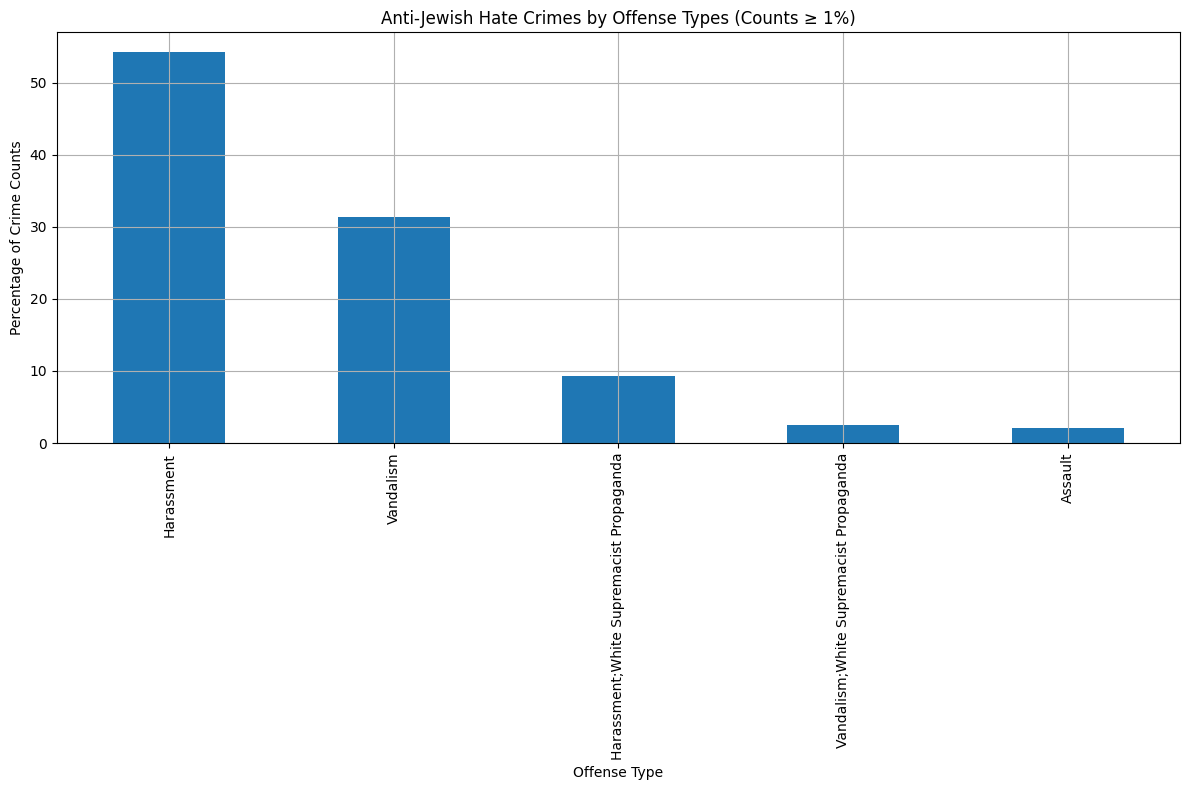

In [27]:
# Calculate the percentage of each offense type
crime_percentage_per_offense = adl_antisemetic_data['offense type'].value_counts(normalize=True) * 100

# Filter offense types with counts below 1%
crime_percentage_per_offense = crime_percentage_per_offense[crime_percentage_per_offense >= 1]

# Plotting
plt.figure(figsize=(12, 8))
crime_percentage_per_offense.plot(kind='bar')
plt.title('Anti-Jewish Hate Crimes by Offense Types (Counts ≥ 1%)')
plt.xlabel('Offense Type')
plt.ylabel('Percentage of Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()



## Analysis, hypothesis testing, & ML

After performing EDA and seeing the different trends in hate crimes, we built a predictive model based on the FBI data for antisemitism over the years. Our approach involves two models - one based on the FBI data and one using additional data from the ADL, which contains more recent data. We first process and perform EDA on the ADL data, compare it to the FBI data, and then build the models.

Why We Chose the Models  
To predict hate crime counts and understand the relationships between various factors, we selected a linear regression model, a chi-square test for independence, and a decision tree regression model. Here's why:

Linear Regression Model:
- Predictive Power: Linear regression is effective for understanding and predicting the relationship between a dependent variable and one or more independent variables. It helps in identifying trends and making future predictions based on historical data.
- Interpretability: The coefficients in linear regression provide a clear understanding of the impact of each predictor on the target variable, aiding in interpreting the results.

Chi-Square Test for Independence:
- Statistical Insight: This test helps analyze the independence between categorical variables, such as 'state_name' and 'hate_crime_count'. It is crucial for determining whether the occurrence of hate crimes is dependent on specific states.
- Model Validation: The chi-square test is used to validate our linear model's results, ensuring that the observed relationships are statistically significant.

Decision Tree Regression Model:
- Non-Linear Relationships: Decision trees capture non-linear relationships between predictors and the target variable, which might not be adequately modeled by linear regression.  
- Feature Importance: Decision trees provide insights into the most significant factors influencing hate crime counts, helping us understand the key drivers behind these incidents.  
- Ease of Interpretation: The structure of decision trees makes it easy to interpret how different features impact predictions, offering a transparent view of the decision-making process.    
By combining these methods, we aim to achieve a robust and comprehensive analysis of hate crime data. The linear regression model provides a baseline predictive capability, the chi-square test validates our assumptions about independence, and the decision tree regression model captures complex interactions and non-linear patterns in the data. This multifaceted approach ensures a thorough understanding of the factors influencing hate crimes and enhances the accuracy and reliability of our predictions.

In [19]:
anti_jewish_data = expanded_data[expanded_data['bias_desc'] == 'Anti-Jewish'][['data_year', 'state_name']]

print(anti_jewish_data)


        data_year     state_name
13           1991        Arizona
19           1991        Arizona
26           1991        Arizona
38           1991        Arizona
39           1991        Arizona
...           ...            ...
241556       2022      Wisconsin
241580       2022      Wisconsin
241608       2022  West Virginia
241626       2022  West Virginia
241632       2022  West Virginia

[30654 rows x 2 columns]


#### Feature Engineering and Model Building
We split the data into features (X) and target variable (y), and perform one-hot encoding for categorical features. Then, we split the data into training and testing sets using the train_test_split function. We train a linear regression model to predict the hate crime counts based on the features. After training the model, we evaluate its performance using mean squared error (MSE). Additionally, we perform a chi-square test to analyze the independence between 'state_name' and 'hate_crime_count'. Lastly, we train a decision tree regression model and evaluate its performance using MSE. This analysis helps us understand the relationship between the occurrence of hate crimes and various factors such as time and location, and enables us to make predictions using machine learning models. 

In [20]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = anti_jewish_data.groupby(['data_year', 'state_name']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state_name']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state_name'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 237.44848886754707


After performing linear regression to predict hate crime counts based on time and location, the mean squared error (MSE) of 237.45 indicates a relatively close alignment between predicted and actual counts on average, though its interpretation can be based on several factors. This is a good first step but indicative of further study being required.

In [21]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = anti_jewish_data.groupby(['data_year', 'state_name']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state_name']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state_name'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 237.44848886754707


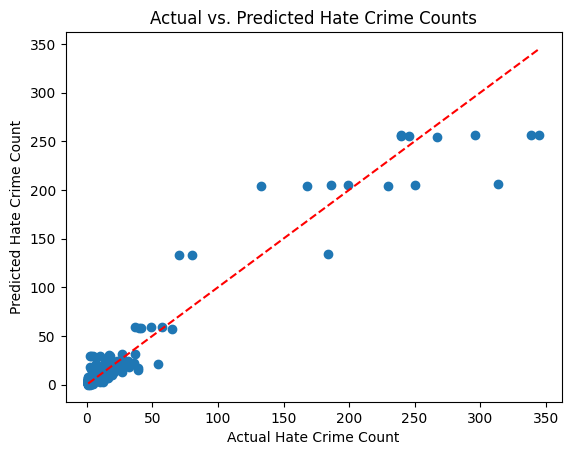

In [22]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Hate Crime Count')
plt.ylabel('Predicted Hate Crime Count')
plt.title('Actual vs. Predicted Hate Crime Counts')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line

plt.show()

In [23]:

contingency_table = pd.crosstab(new_df['state_name'], new_df['hate_crime_count'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Chi-square statistic:', chi2)
print('p-value:', p)

Chi-square statistic: 7472.37029473799
p-value: 0.7297922475710367


The p-value of 0.7298 is and the high Chi-square statistic both indicate that there is a significant difference between the actual and predicted hate crime counts. Future models should take this into account to refine accuracy and efficiency.

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the decision tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print('Decision Tree MSE:', mse_dt)

Decision Tree MSE: 208.77551020408163


### Feature Engineering and Model Building ADL Data
This data includes up until 2023 - because of the increase in rates, using the same linear model doesn't work as well.

We are building another model to identify the relationship between year, state, and crime counts based on the ADL data. 

Mean Squared Error: 10443.362509130906


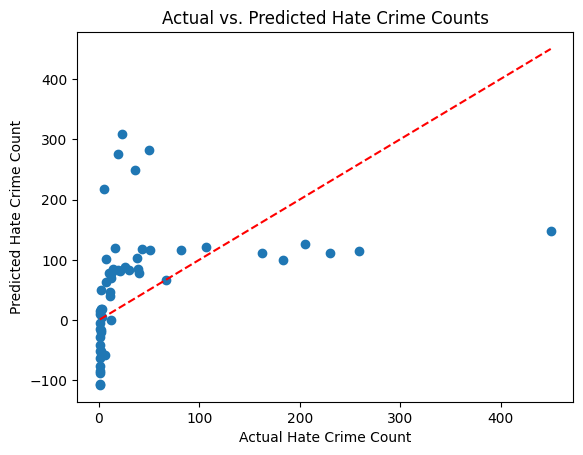

In [25]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = adl_antisemetic_data.groupby(['data_year', 'state']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state'])

# Train-Test Split
X_train, X_test, y_train, adl_y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
adl_y_pred = model.predict(X_test)
mse = mean_squared_error(adl_y_test, adl_y_pred)
print('Mean Squared Error:', mse)

plt.scatter(adl_y_test, adl_y_pred)
plt.xlabel('Actual Hate Crime Count')
plt.ylabel('Predicted Hate Crime Count')
plt.title('Actual vs. Predicted Hate Crime Counts')

plt.plot([min(adl_y_test), max(adl_y_test)], [min(adl_y_test), max(adl_y_test)], color='red', linestyle='--')  # Diagonal line

plt.show()


In [31]:
# Create the contingency table
contingency_table = pd.crosstab(new_df['state'], new_df['hate_crime_count'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the test statistics
print('Chi-square statistic:', chi2)
print('p-value:', p)

# Initialize the decision tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the decision tree model
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse_dt = mean_squared_error(adl_y_test, y_pred_dt)
print('Decision Tree MSE:', mse_dt)

Chi-square statistic: 3762.5022248123387
p-value: 0.9836732428763096
Decision Tree MSE: 7602.090909090909


## Insight & Policy Decision

While our analysis didn't uncover a statistically significant linear trend in hate crime occurrences over time, it's evident that understanding these trends goes beyond just the progression of time. Factors like national and international events, political climates, socioeconomic conditions, and media influence all contribute to the fluctuation of hate crime incidents. Much can be learned from this analysis of hate crimes, and there is space for further study to be done.

Notably, certain states, particularly New York, New Jersey, and California, contributed to the overall count of hate crimes (and especially anti-Jewish crimes) much more than other states. Further investigation into these states' dynamics could unveil insightful trends and potential drivers of hate crimes.

Additionally, from the FBI data an astounding 89.3% of Anti-Jewish incidents were either destruction or property or intimidation incidents. For all incidents, the total of these two types was just under 60%. Delving deeper into the implications and root causes of these incident types could shed light on effective limitation strategies.

Despite the absence of a clear linear trend, the overall uptick in hate crimes underscores the urgency for proactive measures. Beyond statistical modeling, exploring advanced techniques like time series analysis and machine learning could provide a more nuanced understanding of hate crime dynamics.

One specific avenue that can be pursued utilizing the results of this study is the implementation of targeted interventions in areas with high hate crime rates or specific bias types. The states such as New York, New Jersey, and California contain the largest quantity of incidents. Tailored strategies in these hotspots could involve community-based programs, enhanced law enforcement training, and public awareness campaigns focused on fostering tolerance and understanding. Additionally addressing the high incidence of destruction of property and intimidation within anti-Jewish hate crimes through specialized support services and preventative measures can mitigate the impact on affected communities. By concentrating efforts where they are most needed, these targeted interventions can effectively reduce hate crime occurrences and support vulnerable populations.

Further legislative efforts condemning all forms of hatred and holding individuals accountable through the enforcement of zero-tolerance policies can significantly impact the fight against hate crimes. For example, implementing strict anti-hate policies at universities can create safer and more inclusive environments. While the ultimate goal is to foster connection, unity, and build bridges between different communities, immediate measures are necessary to curb hate incidents in the short term. These can include stricter enforcement of existing laws, enhanced reporting mechanisms, and increased support for victims. By combining long-term community-building efforts with immediate, actionable policies, we can create a more tolerant and cohesive society.

Ultimately, understanding (and therefore addressing) hate crimes requires multifaceted approaches encompassing education, community engagement, law enforcement strategies, and policy interventions. Furthering awareness of the issues through studies such as this establish the groundwork through which change can be made, and by delving into these complexities, we can work towards fostering safer and more inclusive societies.

Policy Implications:
Targeted Interventions: Discuss the need for targeted interventions in areas with high hate crime rates or specific bias types, based on the geographic and bias type analysis.
Community Engagement: Emphasize the importance of community engagement and support programs to address underlying causes of hate crimes and promote tolerance and understanding.
Law Enforcement Training: Advocate for specialized training for law enforcement agencies to effectively identify, report, and respond to hate crimes.
Legislative Measures: Propose legislative measures to strengthen hate crime laws, enhance reporting mechanisms, and ensure adequate support for victims and affected communities.
